In [1]:
!pip install pyspark

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
!tar xf spark-3.2.1-bin-hadoop2.7.tgz

!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

     |████████████████████████████████| 281.4 MB 40 kB/s 
     |████████████████████████████████| 198 kB 67.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=a2d1fda036fec4411c7632bd2a48eae101531758cb1e8f11354b00987e5d4521
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [2]:
### Initialize the spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [3]:
import pyspark.ml as ml

In [4]:
# Load the dataset
car_df  = spark.read.csv('Car_sales.csv',inferSchema=True,header=True)

In [5]:
car_df.show(5, truncate=False)

+------------+-------+------------------+----------------------+------------+------------------+-----------+----------+---------+-----+------+-----------+-------------+---------------+-------------+-----------------+
|Manufacturer|Model  |Sales_in_thousands|four_year_resale_value|Vehicle_type|Price_in_thousands|Engine_size|Horsepower|Wheelbase|Width|Length|Curb_weight|Fuel_capacity|Fuel_efficiency|Latest_Launch|Power_perf_factor|
+------------+-------+------------------+----------------------+------------+------------------+-----------+----------+---------+-----+------+-----------+-------------+---------------+-------------+-----------------+
|Acura       |Integra|16.919            |16.36                 |Passenger   |21.5              |1.8        |140       |101.2    |67.3 |172.4 |2.639      |13.2         |28             |2/2/2012     |58.28014952      |
|Acura       |TL     |39.384            |19.875                |Passenger   |28.4              |3.2        |225       |108.1    |70.

In [6]:
car_df = car_df.drop("four_year_resale_value","Latest_Launch")

In [7]:
car_df = car_df.na.drop()

In [8]:
print((car_df.count(),len(car_df.columns)))

(152, 14)


In [9]:
final_car_df = car_df

In [10]:

final_car_df.describe("Sales_in_thousands", "Manufacturer").show()

+-------+------------------+------------+
|summary|Sales_in_thousands|Manufacturer|
+-------+------------------+------------+
|  count|               152|         152|
|   mean|53.359072368421046|        null|
| stddev| 68.93837994118559|        null|
|    min|              0.11|       Acura|
|    max|           540.561|       Volvo|
+-------+------------------+------------+



In [11]:
from pyspark.sql.functions import mean, min, max
final_car_df.select([max('Sales_in_thousands'), mean('Sales_in_thousands'), min('Sales_in_thousands')] ).show()

+-----------------------+-----------------------+-----------------------+
|max(Sales_in_thousands)|avg(Sales_in_thousands)|min(Sales_in_thousands)|
+-----------------------+-----------------------+-----------------------+
|                540.561|     53.359072368421046|                   0.11|
+-----------------------+-----------------------+-----------------------+



In [12]:
from pyspark.sql.functions import avg, stddev

Sales_model_avg_df = final_car_df.groupBy('model').agg(avg('Sales_in_thousands'))
Sales_model_avg_df.show()

+-------------+-----------------------+
|        model|avg(Sales_in_thousands)|
+-------------+-----------------------+
|       Cirrus|                 32.306|
|      Contour|                 35.068|
|        RX300|                 51.238|
|     Villager|                  20.38|
|           SC|                 24.546|
|      Cutlass|                  1.112|
|           SL|                  80.62|
|        Camry|                247.994|
|    Ram Wagon|                 16.767|
|      Outback|                 47.107|
|         300M|                 30.696|
|           A6|                  18.78|
|Grand Marquis|                 81.174|
|         Golf|                  9.761|
|     Forester|                 33.028|
|       Sentra|                 42.643|
|     Cherokee|                 80.556|
|        Focus|                 175.67|
|     Wrangler|                 55.557|
|          SLK|                  7.998|
+-------------+-----------------------+
only showing top 20 rows



In [13]:
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [14]:
Sales_pd = final_car_df.select('Sales_in_thousands').toPandas()

In [15]:
Sales_pd.head()

,Sales_in_thousands
0,16.919
1,39.384
2,8.588
3,20.397
4,18.780


In [16]:
import pandas as pd

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


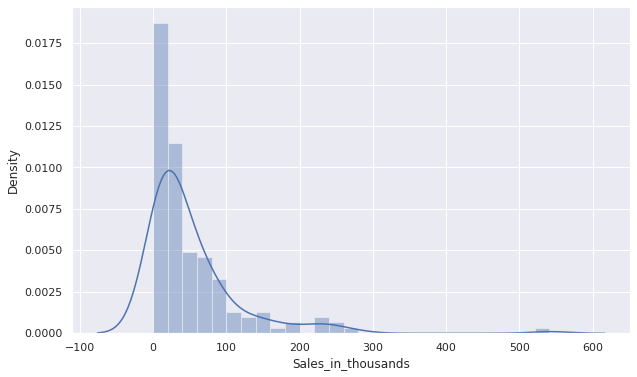

In [17]:
#Density Plot
sn.set(rc={"figure.figsize": (10, 6)})
sn.distplot(pd.to_numeric(Sales_pd['Sales_in_thousands']), norm_hist=True)

In [18]:
import numpy as np
from pyspark.mllib.stat import Statistics

In [19]:
from pyspark.sql.functions import desc

sales_by_manufacturer_df = final_car_df.groupBy('Manufacturer').agg(avg('Sales_in_thousands')).sort( desc( 'avg(Sales_in_thousands)') )

In [20]:
sales_by_manufacturer_df.toPandas()[0:10]

,Manufacturer,avg(Sales_in_thousands)
0,Ford,183.875909
1,Honda,118.534800
2,Jeep,97.717667
3,Toyota,82.245000
4,Dodge,82.212100
5,Pontiac,61.755667
6,Chevrolet,61.596111
7,Buick,60.504750
8,Nissan,57.090714
9,Hyundai,45.775333


In [21]:
top_10_manufacturer = sales_by_manufacturer_df.toPandas()[0:10]

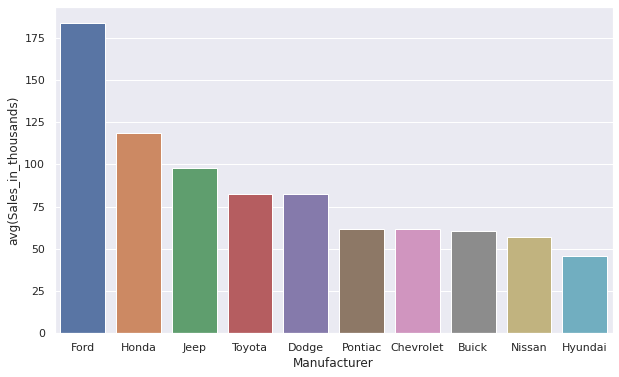

In [22]:
sn.barplot( data = top_10_manufacturer,
          x='Manufacturer',
          y='avg(Sales_in_thousands)',
          order = top_10_manufacturer.Manufacturer)

In [23]:
from pyspark.sql.functions import col, log
final_car_df = final_car_df.withColumn( 'log_Sales_in_thousands', log('Sales_in_thousands') )

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


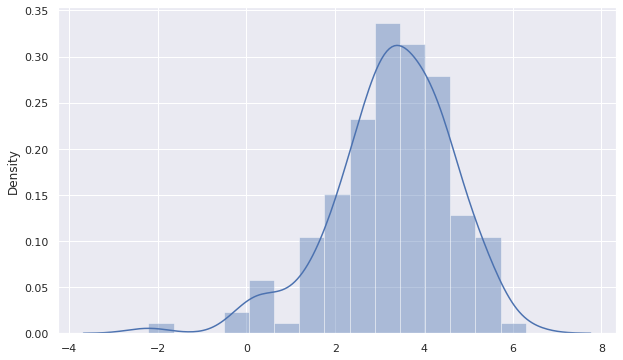

In [24]:
sn.set(rc={"figure.figsize": (10, 6)})
sn.distplot(final_car_df.select('log_Sales_in_thousands').toPandas(), norm_hist=True)

In [75]:
#Columns that will be used as features and their types
continuous_features = ['Price_in_thousands','Engine_size','Fuel_capacity', 'Fuel_efficiency']

categorical_features = ['Manufacturer',  'Vehicle_type']

In [76]:
#Encoding all categorical features
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, PolynomialExpansion, VectorIndexer

In [79]:
# create object of StringIndexer class and specify input and output column
SI_Manufacturer = StringIndexer(inputCol='Manufacturer',outputCol='Manufacturer_Index1')

SI_Vehicle_type = StringIndexer(inputCol='Vehicle_type',outputCol='Vehicle_type_Index1')


# transform the data
final_car_df = SI_Manufacturer.fit(final_car_df).transform(final_car_df)

final_car_df = SI_Vehicle_type.fit(final_car_df).transform(final_car_df)




# view the transformed data
final_car_df.select('Manufacturer', 'Manufacturer_Index1',  'Vehicle_type', 'Vehicle_type_Index1').show(10)


+------------+-------------------+------------+-------------------+
|Manufacturer|Manufacturer_Index1|Vehicle_type|Vehicle_type_Index1|
+------------+-------------------+------------+-------------------+
|       Acura|               19.0|   Passenger|                0.0|
|       Acura|               19.0|   Passenger|                0.0|
|       Acura|               19.0|   Passenger|                0.0|
|        Audi|               20.0|   Passenger|                0.0|
|        Audi|               20.0|   Passenger|                0.0|
|        Audi|               20.0|   Passenger|                0.0|
|         BMW|               21.0|   Passenger|                0.0|
|         BMW|               21.0|   Passenger|                0.0|
|         BMW|               21.0|   Passenger|                0.0|
|       Buick|               16.0|   Passenger|                0.0|
+------------+-------------------+------------+-------------------+
only showing top 10 rows



In [80]:
# create object and specify input and output column
OHE = OneHotEncoder(inputCols=['Manufacturer_Index1', 'Vehicle_type_Index1' ],outputCols=['Manufacturer_vector1','Vehicle_type_vector1'])

# transform the data
final_car_df = OHE.fit(final_car_df).transform(final_car_df)

# view and transform the data
final_car_df.select('Manufacturer', 'Manufacturer_Index1', 'Manufacturer_vector1',  'Vehicle_type', 'Vehicle_type_Index1', 'Vehicle_type_vector1').show(10)

+------------+-------------------+--------------------+------------+-------------------+--------------------+
|Manufacturer|Manufacturer_Index1|Manufacturer_vector1|Vehicle_type|Vehicle_type_Index1|Vehicle_type_vector1|
+------------+-------------------+--------------------+------------+-------------------+--------------------+
|       Acura|               19.0|     (29,[19],[1.0])|   Passenger|                0.0|       (1,[0],[1.0])|
|       Acura|               19.0|     (29,[19],[1.0])|   Passenger|                0.0|       (1,[0],[1.0])|
|       Acura|               19.0|     (29,[19],[1.0])|   Passenger|                0.0|       (1,[0],[1.0])|
|        Audi|               20.0|     (29,[20],[1.0])|   Passenger|                0.0|       (1,[0],[1.0])|
|        Audi|               20.0|     (29,[20],[1.0])|   Passenger|                0.0|       (1,[0],[1.0])|
|        Audi|               20.0|     (29,[20],[1.0])|   Passenger|                0.0|       (1,[0],[1.0])|
|         

In [81]:
#Create vectors from all features column
featureCols = continuous_features + ['Manufacturer_vector1',  'Vehicle_type_vector1']                           

In [82]:
featureCols

['Price_in_thousands',
 'Engine_size',
 'Fuel_capacity',
 'Fuel_efficiency',
 'Manufacturer_vector1',
 'Vehicle_type_vector1']

In [83]:
final_car_df.show()

+------------+-----------+------------------+------------+------------------+-----------+----------+---------+-----+------+-----------+-------------+---------------+-----------------+----------------------+-----------------+----------+-----------------+-------------------+-----------------+-------------------+-----------------+----------+-----------------+------------------+-------------------+-------------------+--------------------+--------------------+
|Manufacturer|      Model|Sales_in_thousands|Vehicle_type|Price_in_thousands|Engine_size|Horsepower|Wheelbase|Width|Length|Curb_weight|Fuel_capacity|Fuel_efficiency|Power_perf_factor|log_Sales_in_thousands|Manufacturer_Idx1|Model_Idx1|Vehicle_type_Idx1|Manufacturer_vector|     Model_vector|Vehicle_type_vector|Manufacturer_Idx2|Model_Idx2|Vehicle_type_Idx2|Manufacturer_Index|Manufacturer_Index1|Vehicle_type_Index1|Manufacturer_vector1|Vehicle_type_vector1|
+------------+-----------+------------------+------------+------------------+---

In [84]:
assembler = VectorAssembler( inputCols = featureCols, outputCol = "features")

In [85]:
final_car_train_df = assembler.transform( final_car_df )

In [86]:
from pyspark.sql.functions import round

final_car_train_df = final_car_train_df.withColumn( "label", round('log_Sales_in_thousands', 4) )

In [87]:
#Split the dataset
train_df, test_df = final_car_train_df.randomSplit( [0.7, 0.3], seed = 42 )

In [88]:
#Build the Linear Regression Model
from pyspark.ml.regression import LinearRegression

In [89]:
final_car_train_df.show()

+------------+-----------+------------------+------------+------------------+-----------+----------+---------+-----+------+-----------+-------------+---------------+-----------------+----------------------+-----------------+----------+-----------------+-------------------+-----------------+-------------------+-----------------+----------+-----------------+------------------+-------------------+-------------------+--------------------+--------------------+--------------------+------+
|Manufacturer|      Model|Sales_in_thousands|Vehicle_type|Price_in_thousands|Engine_size|Horsepower|Wheelbase|Width|Length|Curb_weight|Fuel_capacity|Fuel_efficiency|Power_perf_factor|log_Sales_in_thousands|Manufacturer_Idx1|Model_Idx1|Vehicle_type_Idx1|Manufacturer_vector|     Model_vector|Vehicle_type_vector|Manufacturer_Idx2|Model_Idx2|Vehicle_type_Idx2|Manufacturer_Index|Manufacturer_Index1|Vehicle_type_Index1|Manufacturer_vector1|Vehicle_type_vector1|            features| label|
+------------+----------

In [90]:
#linreg = LinearRegression(maxIter=500, regParam=0.0)
linreg = LinearRegression()

In [91]:
lm = linreg.fit( train_df )

In [92]:
#Make predictions on train data and evaluate
y_pred_train = lm.transform(train_df)

In [93]:
#Make predictions on test data and evaluate
y_pred_test = lm.transform( test_df )

In [94]:
y_pred_test.select( 'features',  'label', 'prediction', 'Sales_in_thousands' ).show( 5 )

+--------------------+------+------------------+------------------+
|            features| label|        prediction|Sales_in_thousands|
+--------------------+------+------------------+------------------+
|(34,[0,1,2,3,23,3...|3.6734| 2.901906792030189|            39.384|
|(34,[0,1,2,3,25,3...| 2.983|2.7431308633616895|            19.747|
|(34,[0,1,2,3,25,3...|2.8637|1.9805558280335196|            17.527|
|(34,[0,1,2,3,20,3...| 4.517|   4.1528351723834|            91.561|
|(34,[0,1,2,3,21,3...|2.4146| 2.773725270390788|            11.185|
+--------------------+------+------------------+------------------+
only showing top 5 rows



In [95]:
#Calculate the actual predicted price
from pyspark.sql.functions import exp
y_pred_train = y_pred_train.withColumn( "y_pred", exp( 'prediction' ) )
y_pred_test = y_pred_test.withColumn( "y_pred", exp( 'prediction' ) )

In [97]:
#Calculate RMSE
from pyspark.ml.evaluation import RegressionEvaluator

rmse_evaluator = RegressionEvaluator(labelCol="Sales_in_thousands",
                              predictionCol="y_pred",
                              metricName="rmse" )

In [98]:
lm_rmse_train = rmse_evaluator.evaluate( y_pred_train )

In [99]:
lm_rmse_train

39.136095180784174

In [100]:
lm_rmse_test = rmse_evaluator.evaluate( y_pred_test )

In [101]:
lm_rmse_test

90.83713113616658

In [102]:
#Calculate R-squared
r2_evaluator = RegressionEvaluator(labelCol="Sales_in_thousands",
                              predictionCol="y_pred",
                              metricName="r2" )

In [103]:
lm_r2_train = r2_evaluator.evaluate( y_pred_train )
lm_r2_train

0.46829023927851066

In [104]:
lm_r2_test = r2_evaluator.evaluate( y_pred_test )
lm_r2_test

0.04493750674445718

In [105]:
# CREATE PIPELINE

continuous_features

['Price_in_thousands', 'Engine_size', 'Fuel_capacity', 'Fuel_efficiency']

In [106]:
categorical_features

['Manufacturer', 'Vehicle_type']

In [126]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression

## Create indexers for the categorical features
indexers = [StringIndexer(inputCol=c, outputCol="{}_idx".format(c)) for c in categorical_features]

## encode the categorical features
encoders = [ OneHotEncoder(
      inputCol=idx.getOutputCol(),
      outputCol="{0}_enc".format(idx.getOutputCol())) for idx in indexers]

## Create vectors for all features categorical and continuous

assembler = VectorAssembler(
  inputCols=[enc.getOutputCol() for enc in encoders] + continuous_features,
  outputCol="features")

## Initialize the linear model
lrModel = LinearRegression( maxIter = 10 )


## Create the pipeline with sequence of activities
pipeline = Pipeline( stages=indexers + encoders + [assembler, lrModel ])

#pipeline = Pipeline( stages= [indexers, encoders, assembler, lrModel ])

In [127]:
car_pipeline_df = final_car_df.withColumn( 'label', round( log( 'Sales_in_thousands' ), 4) )

In [128]:
training, testing = car_pipeline_df.randomSplit( [0.7, 0.3], seed = 42 )

In [129]:
training.show(5)

+------------+-------+------------------+------------+------------------+-----------+----------+---------+-----+------+-----------+-------------+---------------+-----------------+----------------------+-----------------+----------+-----------------+-------------------+-----------------+-------------------+-----------------+----------+-----------------+------------------+-------------------+-------------------+--------------------+--------------------+-------------------+-------------------+----------------+----------------+------+
|Manufacturer|  Model|Sales_in_thousands|Vehicle_type|Price_in_thousands|Engine_size|Horsepower|Wheelbase|Width|Length|Curb_weight|Fuel_capacity|Fuel_efficiency|Power_perf_factor|log_Sales_in_thousands|Manufacturer_Idx1|Model_Idx1|Vehicle_type_Idx1|Manufacturer_vector|     Model_vector|Vehicle_type_vector|Manufacturer_Idx2|Model_Idx2|Vehicle_type_Idx2|Manufacturer_Index|Manufacturer_Index1|Vehicle_type_Index1|Manufacturer_vector1|Vehicle_type_vector1|Manufact

In [130]:
model = pipeline.fit( training )

In [131]:
y_pred_train = model.transform(training)

In [132]:
model.save("linear_regression.model")

In [133]:
!zip -r /content/linear_regression_model.zip /content/linear_regression.model

  adding: content/linear_regression.model/ (stored 0%)
  adding: content/linear_regression.model/stages/ (stored 0%)
  adding: content/linear_regression.model/stages/1_StringIndexer_abd67a335fca/ (stored 0%)
  adding: content/linear_regression.model/stages/1_StringIndexer_abd67a335fca/data/ (stored 0%)
  adding: content/linear_regression.model/stages/1_StringIndexer_abd67a335fca/data/.part-00000-cde5f93f-5d4b-43d6-b779-bd159ff4d239-c000.snappy.parquet.crc (stored 0%)
  adding: content/linear_regression.model/stages/1_StringIndexer_abd67a335fca/data/part-00000-cde5f93f-5d4b-43d6-b779-bd159ff4d239-c000.snappy.parquet (deflated 36%)
  adding: content/linear_regression.model/stages/1_StringIndexer_abd67a335fca/data/_SUCCESS (stored 0%)
  adding: content/linear_regression.model/stages/1_StringIndexer_abd67a335fca/data/._SUCCESS.crc (stored 0%)
  adding: content/linear_regression.model/stages/1_StringIndexer_abd67a335fca/metadata/ (stored 0%)
  adding: content/linear_regression.model/stages/